Analysis of the Kepler-76 b data

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from glob import glob

from astropy import units as u

from statsmodels.robust.scale import mad
from scipy.optimize import curve_fit
from numpy.random import normal

from lightkurve import KeplerLightCurveFile

from evilmc import evparams, evmodel, convert_Kz
from transit_utils import median_boxcar_filter, bindata, transit_duration, flag_outliers, fit_eclipse_bottom
from variable_eclipses_utils import retreive_data

from PyAstronomy.pyasl import isInTransit

binsize = 1./60./24

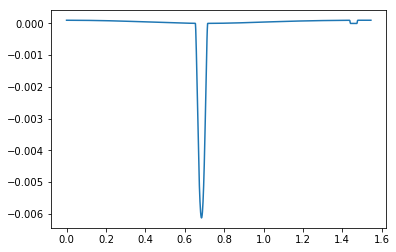

In [6]:
# From Faigler+ (2013 - http://iopscience.iop.org/article/10.1088/0004-637X/771/1/26/meta)
# The system parameters as reported in Faigler et al. (2013) --
#  http://iopscience.iop.org/article/10.1088/0004-637X/771/1/26/meta
a = 1./0.221 #± 0.003
b = 0.944 # ± 0.011
per = 1.54492875*u.day # ± 0.00000027
Kz_m_per_s = 308. # ± 20.
Kz = convert_Kz(Kz=Kz_m_per_s) # convert to fraction of the speed of light

Mp = 2.00*u.jupiterMass # ± 0.26
Rp_over_a = 0.0214 # ± 0.0008
Rp_over_Rs = Rp_over_a*a
Ms = 1.2*u.solMass # ± 0.2
q = Mp.to('kg')/Ms.to('kg')

vsini = 6500.*u.m/u.s # ± 2000
Rs = 1.32*u.solRad #± 0.08
Omegas = vsini.to('m/s')/Rs.to('m')*per.to('s') # stellar rotation state - very little effect, so chosen arbitrarily

Ts = 6300. # ± 200
Faigler_T0 = (737.49 + 2455000. - 2454833.) % per.to('day').value # ±0.19
T0 = 0.68508434

coeffs = [0.313, 0.304]

Aplanet = 50.4e-6 # ± 2.0
F0 = 50.4e-6 # ± 2.0 -- overall shift in light curve, which is arbitrary
phase_shift = 10.3/360. # ± 2.0 - convert phase shift angle from degrees to orbital phase

beta = 0.0716671 # Interpolation from among the values reported in Claret & Bloemen (2011) A&A 529, 75

# Save parameters to an evilmc parameters object
ep = evparams(per=per.to('day').value, a=a, T0=T0, p=Rp_over_Rs, limb_dark="quadratic", b=b, 
              F0=F0, Aplanet=Aplanet, phase_shift=phase_shift, beta=beta, q=q, Kz=Kz, Ts=Ts, Ws=[0.,0.,Omegas], 
              u=coeffs)
time = np.linspace(0, per.to('day').value, 1000)
em = evmodel(time, ep)

plt.plot(time, em.all_signals())

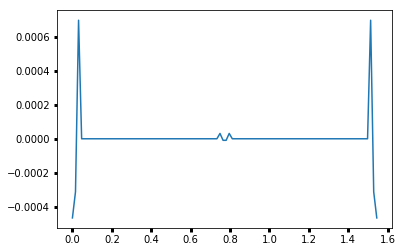

In [4]:
convolved_em = evmodel(time, ep, supersample_factor=5, exp_time=30./60./24.)

plt.plot(time, em.all_signals() - convolved_em.all_signals())

/Users/brian/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median for 94 results
  r = func(a, **kwargs)
/Users/brian/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


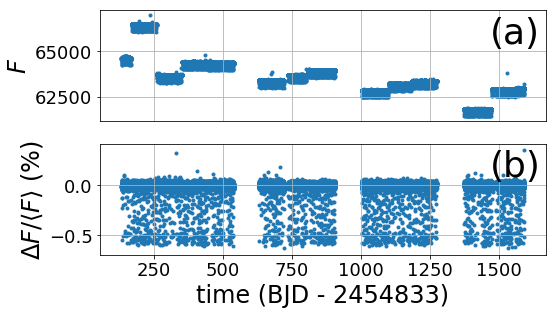

In [3]:
fig = plt.figure(figsize=(8, 4.5))

ax1 = fig.add_subplot(211)
ax1.tick_params(which='both', labelbottom=False, bottom=False)
ax1.tick_params(which='major', axis='y', labelsize=18)
ax1.grid(True)
ax1.set_ylabel("$F$", fontsize=24)
ax1.annotate("(a)", xy=(0.875, 0.7), xytext=(0.875, 0.7), fontsize=36, xycoords='axes fraction')

ax2 = fig.add_subplot(212, sharex=ax1)
ax2.grid(True)
ax2.set_xlabel("time (BJD - 2454833)", fontsize=24)
ax2.set_ylabel("$\Delta F/\\langle F \\rangle$ (%)", fontsize=24)
ax2.tick_params(which='both', labelsize=18)
ax2.annotate("(b)", xy=(0.875, 0.7), xytext=(0.875, 0.7), fontsize=36, xycoords='axes fraction')

# for q in range(0, 18):
KIC = 4570949
base_dir = "mastDownload/Kepler/"
time, flux, filtered_time, filtered_flux = retreive_data(per.to('day').value, params=ep)

ax1.scatter(time, flux, marker='.')
ax2.scatter(filtered_time, filtered_flux*100, marker='.')

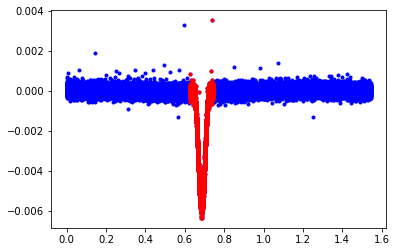

In [4]:
folded_time = filtered_time % ep.per
# Indicate all points in transit
dur = transit_duration(ep, which_duration='full')
ind = np.abs(folded_time - T0) < dur

plt.plot(folded_time, filtered_flux, 'b.')
plt.plot(folded_time[ind], filtered_flux[ind], 'r.')

CPU times: user 12.6 s, sys: 17.8 s, total: 30.4 s
Wall time: 34.8 s


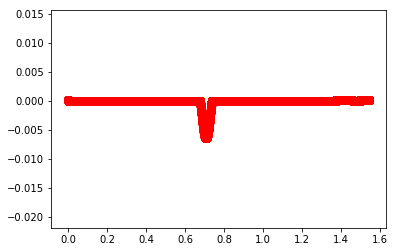

In [7]:
ep = evparams(per=per.to('day').value, a=a, T0=Faigler_T0, p=Rp_over_Rs, 
              limb_dark="quadratic", b=1./0.221*np.cos(78.0*np.pi/180.), 
              F0=0., Aplanet=50.4e-6, phase_shift=0., beta=0.07, q=q, Kz=Kz, Ts=Ts, Ws=[0.,0.,Omegas], u=coeffs)
em = evmodel(folded_time, ep)
%time plt.scatter(folded_time, em.all_signals())

(0.7066812502235398, array([0.68507666]), array([0.000381]))
(0.09683257918552035, 0.09683257918552035, 0.944)


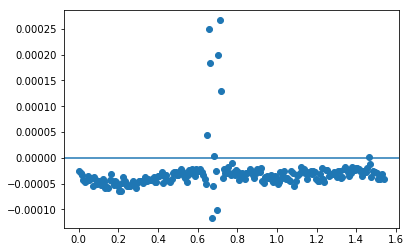

In [8]:
def fit_signal(time, T0):
    ep = saved_ep
    ep.T0 = T0
    em = evmodel(time, ep, supersample_factor=5, exp_time=30./60./24.)
    
    return em.all_signals()


initial_guess = Faigler_T0
popt, pcov = curve_fit(fit_signal, binned_time, binned_flux,
                       sigma=binned_err,
                       p0=initial_guess, 
                       bounds=(Faigler_T0 - 0.1, Faigler_T0 + 0.1))
print(Faigler_T0, popt, np.sqrt(pcov.diagonal()))
# T0 = popt[0]
popt = [0.68508434]
T0 = 0.68508434

ep = evparams(per=per.to('day').value, a=a, T0=T0, p=Rp_over_Rs, 
              limb_dark="quadratic", b=b, 
              F0=50.4e-6, Aplanet=50.4e-6, phase_shift=0., beta=0.07, q=q, Kz=Kz, Ts=Ts, Ws=[0.,0.,Omegas], u=coeffs)
saved_ep = evparams(per=per.to('day').value, a=a, T0=T0, p=Rp_over_Rs,
                    limb_dark="quadratic", b=b, 
              F0=50.4e-6, Aplanet=50.4e-6, phase_shift=0., beta=0.07, q=q, Kz=Kz, Ts=Ts, Ws=[0.,0.,Omegas], u=coeffs)

print(Rp_over_Rs, saved_ep.p, saved_ep.b)

# 2018 Jul 10 - Shift data so eclipse coincides to zero
eclipse_bottom = fit_eclipse_bottom(binned_time, binned_flux, ep, which_duration='center')
#binned_flux -= eclipse_bottom

# plt.plot(binned_time, fit_signal(binned_time, *popt), color='red', lw=3)
# plt.plot(binned_time, binned_flux, marker='o', ls='')
# plt.xlim([1.4, 1.6])
# plt.ylim([-0.0005, 0.0002])
#plt.xlim([0.625, 0.75])
plt.axhline(0.)

plt.plot(binned_time, binned_flux - fit_signal(binned_time, *popt), marker='o', ls='')

-0.9448938319224592
(array([-0.94489382]), array([[0.00077479]]))


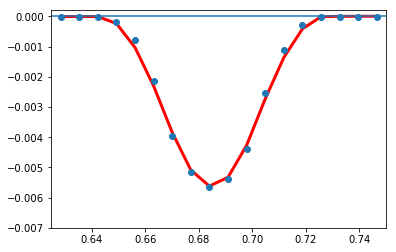

In [11]:
def fit_signal(time, b):
    ep = saved_ep
    ep.b = b
    em = evmodel(time, ep, supersample_factor=5, exp_time=30./60./24.)
    
    return em.all_signals()

ind = (binned_time > 0.625) & (binned_time < 0.75)

initial_guess = [0.]
popt, pcov = curve_fit(fit_signal, binned_time[ind], binned_flux[ind],
                       sigma=binned_err[ind],
                       p0=initial_guess, 
                       bounds=(-1.1, 1.1))
print(saved_ep.b)
print(popt, np.sqrt(pcov))

ep = evparams(per=per.to('day').value, a=a, T0=T0, p=Rp_over_Rs, 
              limb_dark="quadratic", b=popt[0], 
              F0=50.4e-6, Aplanet=50.4e-6, phase_shift=0., beta=0.07, q=q, Kz=Kz, Ts=Ts, Ws=[0.,0.,Omegas], u=coeffs)

plt.plot(binned_time[ind], fit_signal(binned_time[ind], *popt), color='red', lw=3)
plt.plot(binned_time[ind], binned_flux[ind], marker='o', ls='')
plt.ylim([-0.007, 0.0002])
plt.xlim([0.625, 0.75])
plt.axhline(0.)

(0.00937654839172007, -0.009376548391720085, -0.009376548391720085)


(0.6770941489095093, 0.718760815576176)

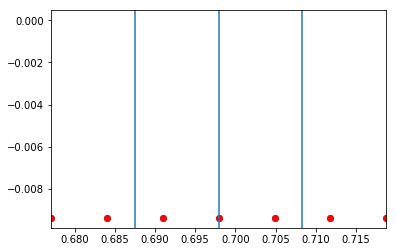

In [89]:
def signal_no_average(time, p, b, u1, u2, fit_q):
    ep = evparams(per=per.to('day').value, a=a, T0=T0, p=Rp_over_Rs, limb_dark="quadratic", b=b, 
              F0=0., Aplanet=0., phase_shift=0., beta=0., q=q, Kz=0., Ts=Ts, Ws=[0.,0., 0.], u=coeffs)
    ep.q = fit_q
    ep.p = p
    ep.b = b
    ep.u = [u1, u2]
#    ep.F0 = fit_F0
#    ep.Aplanet = fit_Aplanet
    em = evmodel(time, ep)
    
    return em.all_signals()

def signal_average(time, p, b, u1, u2, fit_q):
    ep = evparams(per=per.to('day').value, a=a, T0=T0, p=Rp_over_Rs, limb_dark="quadratic", b=b, 
              F0=0., Aplanet=0., phase_shift=0., beta=0., q=q, Kz=0., Ts=Ts, Ws=[0.,0., 0.], u=coeffs)
    ep.q = fit_q
    ep.p = p
    ep.b = b
    ep.u = [u1, u2]
#    ep.F0 = fit_F0
#    ep.Aplanet = fit_Aplanet
    em = evmodel(time, ep, supersample_factor=5, exp_time=30./60./24.)
    
    return em.all_signals()

no_avg = signal_no_average(binned_time, Rp_over_Rs, 0., 0., 0., 0.)
avg = signal_average(binned_time, Rp_over_Rs, 0., 0., 0., 0.)
print(Rp_over_Rs**2., np.min(no_avg), np.min(avg))
plt.plot(binned_time, no_avg, marker='o', ls='')
plt.plot(binned_time, avg, marker='o', color='red', ls='')
plt.axvline(binned_time[100] - 0.5*30./60./24.)
plt.axvline(binned_time[100])
plt.axvline(binned_time[100] + 0.5*30./60./24.)
#plt.errorbar(binned_time[ind], binned_flux[ind] - fit_signal(binned_time[ind], *popt), binned_err[ind])
#plt.xlim([T0 - 20.*10./60./24., T0 + 20.*10./60./24.])
plt.xlim([binned_time[100] - 30./60./24., binned_time[100] + 30./60./24.])

[0.1, 0.0, 0.313, 0.304, <Quantity 0.00159099>]
(array([ 1.12124281e-01, -9.82328708e-01,  3.90933617e-01,  1.16911805e-06,
        2.71498760e-02]), array([[0.0248188 ,        nan,        nan, 0.18204979,        nan],
       [       nan, 0.01700286, 0.08360709,        nan, 0.01529189],
       [       nan, 0.08360709, 0.99395622,        nan,        nan],
       [0.18204979,        nan,        nan, 1.62844941, 0.03953053],
       [       nan, 0.01529189,        nan, 0.03953053, 0.0282479 ]]))


/Users/brian/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt


(0.625, 0.75)

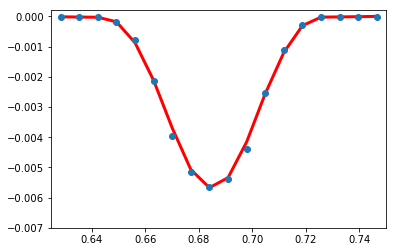

In [93]:
# 2018 Jul 22 - Transit curve doesn't seem to fit well with Faigler's parameters. Let's try changing them.

def fit_signal(time, p, b, u1, u2, fit_q):
    ep = evparams(per=per.to('day').value, a=a, T0=T0, p=Rp_over_Rs, limb_dark="quadratic", b=b, 
              F0=50.4e-6, Aplanet=50.4e-6, phase_shift=0., beta=0.07, q=q, Kz=Kz, Ts=Ts, Ws=[0.,0.,Omegas], u=coeffs)
    ep.q = fit_q
    ep.p = p
    ep.b = b
    ep.u = [u1, u2]
#    ep.F0 = fit_F0
#    ep.Aplanet = fit_Aplanet
    em = evmodel(time, ep, supersample_factor=5, exp_time=30./60./24.)
    
    return em.all_signals()

ind = (binned_time > 0.625) & (binned_time < 0.75)

initial_guess = [0.1, 0., saved_ep.u[0], saved_ep.u[1], q]
# popt, pcov = curve_fit(fit_signal, binned_time[ind], binned_flux[ind],
#                        sigma=binned_err[ind],
#                        p0=initial_guess, 
#                        bounds=([0., -1., 0., 0., 0.], [0.2, 1., 1., 2., 0.1]))

print(initial_guess)
# (array([ 0.09434058, -0.93864375]), array([[0.00690773,        nan],
#        [       nan, 0.01434401]]))
print(popt, np.sqrt(pcov))

ep = evparams(per=per.to('day').value, a=a, T0=T0, p=popt[0], 
              limb_dark="quadratic", b=popt[1], 
              F0=50.4e-6, Aplanet=50.4e-6, phase_shift=0., beta=0.07, q=popt[4], Kz=Kz, Ts=Ts, Ws=[0.,0.,Omegas], 
              u=popt[2:3])

plt.plot(binned_time[ind], fit_signal(binned_time[ind], *popt), color='red', lw=3)
plt.plot(binned_time[ind], binned_flux[ind], marker='o', ls='')
plt.ylim([-0.007, 0.0002])
#plt.plot(binned_time[ind], (binned_flux[ind] - fit_signal(binned_time[ind], *popt))*1e6, marker='o', ls='')
#plt.errorbar(binned_time[ind], binned_flux[ind] - fit_signal(binned_time[ind], *popt), binned_err[ind])
plt.xlim([0.625, 0.75])


[1.0, 1.0]
(array([6.52897657e-07, 6.67589914e-01]), array([[1.23506883,        nan],
       [       nan, 1.5115024 ]]))


/Users/bjackson/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in sqrt


(0.625, 0.75)

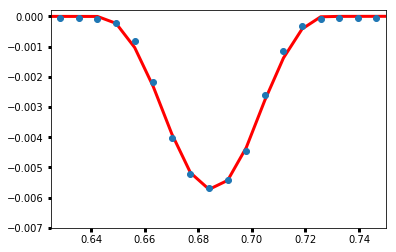

In [40]:
# 2018 Jul 18 - Transit curve doesn't seem to fit well with Faigler's parameters. Let's try changing them.

def fit_signal(time, u1, u2):
    ep = evparams(per=per.to('day').value, a=a, T0=T0, p=Rp_over_Rs, limb_dark="quadratic", b=b, 
              F0=50.4e-6, Aplanet=50.4e-6, phase_shift=0., beta=0.07, q=q, Kz=Kz, Ts=Ts, Ws=[0.,0.,Omegas], u=coeffs)
    ep.u = [u1, u2]
    em = evmodel(time, ep, supersample_factor=5, exp_time=30./60./24.)
    
    return em.all_signals()

initial_guess = [1., 1.]
popt, pcov = curve_fit(fit_signal, binned_time, binned_flux,
                       sigma=binned_err,
                       p0=initial_guess, 
                       bounds=([0., 0.], [1., 1.]))
print(initial_guess)
print(popt, np.sqrt(pcov))

ep = evparams(per=per.to('day').value, a=a, T0=T0, p=Rp_over_Rs, 
              limb_dark="quadratic", b=b, 
              F0=50.4e-6, Aplanet=50.4e-6, phase_shift=0., beta=0.07, q=q, Kz=Kz, Ts=Ts, Ws=[0.,0.,Omegas], 
              u=popt)

plt.plot(binned_time, fit_signal(binned_time, *popt), color='red', lw=3)
plt.plot(binned_time, binned_flux, marker='o', ls='')
plt.ylim([-0.007, 0.0002])
plt.xlim([0.625, 0.75])

#plt.plot(binned_time, binned_flux - fit_signal(binned_time, *popt), marker='o', ls='')

/Users/bjackson/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


([5.04e-05, 5.04e-05, 0.0, <Quantity 0.00159099>], array([ 4.23989247e-05,  4.63758665e-05, -2.06426004e-02,  8.87409603e-04]), array([[3.94976969e-06,            nan,            nan,            nan],
       [           nan, 3.30763989e-06, 3.35496166e-05, 3.32825383e-06],
       [           nan, 3.35496166e-05, 1.04692025e-02, 1.77383691e-04],
       [           nan, 3.32825383e-06, 1.77383691e-04, 2.72193116e-04]]))


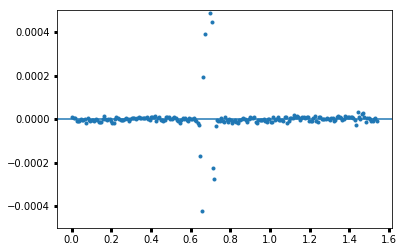

In [34]:
def fit_signal(time, F0, Aplanet, phase_shift, q):
    ep = saved_ep
    ep.F0 = F0
    ep.Aplanet = Aplanet
    ep.phase_shift = phase_shift
    ep.q = q
    em = evmodel(time, ep)
    
    return em.all_signals()

# initial_guess = [50.4e-6, 50.4e-6, 0., q]
# popt, pcov = curve_fit(fit_signal, binned_time, binned_flux,
#                        sigma=binned_err,
#                        p0=initial_guess, 
#                        bounds=([-100e-6, -100e-6, -1., 0.], [100e-6, 100e-6, 1., 1e-2]))
print(initial_guess, popt, np.sqrt(pcov))

F0 = popt[0]
Aplanet = popt[1]
phase_shift = popt[2]
new_q = popt[3]
ep = evparams(per=per.to('day').value, a=a, T0=T0, p=Rp_over_Rs, 
              limb_dark="quadratic", b=1./0.221*np.cos(78.0*np.pi/180.), 
              F0=F0, Aplanet=Aplanet, phase_shift=phase_shift, beta=0.07, q=new_q, Kz=Kz, Ts=Ts, Ws=[0.,0.,Omegas], 
              u=coeffs)

# plt.plot(binned_time, fit_signal(binned_time, *popt), color='red', lw=3)
# plt.plot(binned_time, binned_flux, marker='.', ls='')
# plt.ylim([-0.0005, 0.0002])

plt.plot(binned_time, binned_flux - fit_signal(binned_time, *popt), marker='.', ls='')
plt.ylim([-0.0005, 0.0005])
plt.axhline(0)

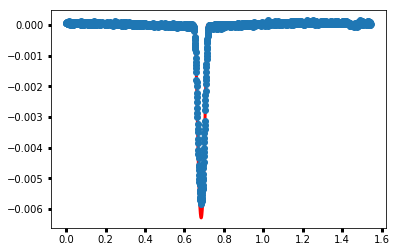

In [30]:
new_ep = evparams(per=per.to('day').value, a=a, T0=T0, p=Rp_over_Rs, 
              limb_dark="quadratic", b=1./0.221*np.cos(78.0*np.pi/180.), 
              F0=50.4e-6, Aplanet=50.4e-6, phase_shift=-10.3/360., beta=0.07, q=q, Kz=Kz, Ts=Ts, Ws=[0.,0.,Omegas], 
                  u=coeffs)
new_em = evmodel(binned_time, new_ep)

plt.plot(binned_time, new_em.all_signals(), color='red', lw=3)
plt.plot(binned_time, binned_flux, marker='o', ls='')

#plt.ylim([-0.0001, 0.0001])

0.0968325791855


(-0.038891333985466944, 0.0420185461627276)

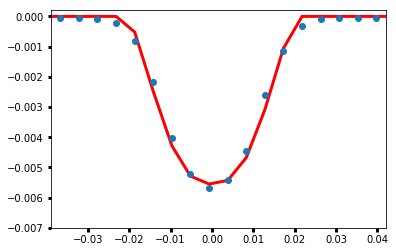

In [20]:
#-0.944871092152674
#1./0.221*np.cos(78.0*np.pi/180.)
print(Rp_over_Rs)
new_ep = evparams(per=per.to('day').value, a=a, T0=T0, p=0.0825, 
              limb_dark="quadratic", b=0.915, 
              F0=0., Aplanet=0., phase_shift=0., beta=0., q=0., Kz=0., Ts=Ts, Ws=[0.,0.,0.], u=coeffs)
new_em = evmodel(binned_time, new_ep)

plt.plot((binned_time - T0)/new_ep.per, new_em.all_signals(), color='red', lw=3)
plt.plot((binned_time - T0)/new_ep.per, binned_flux, marker='o', ls='')

plt.ylim([-0.007, 0.0002])
plt.xlim([(0.625 - T0)/new_ep.per, (0.75 - T0)/new_ep.per])

[0.1, 0.0, <Quantity 0.00159099>]
(array([ 0.11733756, -0.97646101,  0.01      ]), array([0.00163311, 0.00254523, 0.00729776]))


(0.6555418083990827, 0.7146397745498079)

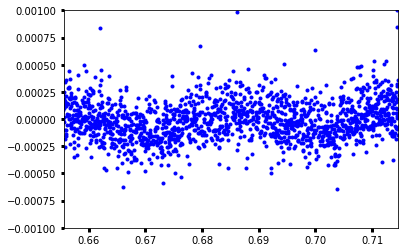

In [29]:
# 2018 Jul 23 - It seems that the binning process is distorting the transit curve. Here's an attempt to fit the curve
# using evilmc and the unbinned data
# 2018 Jul 22 - Transit curve doesn't seem to fit well with Faigler's parameters. Let's try changing them.

def fit_signal(time, p, b, q):
    ep = evparams(per=per.to('day').value, a=a, T0=T0, p=Rp_over_Rs, limb_dark="quadratic", b=b, 
              F0=50.4e-6, Aplanet=50.4e-6, phase_shift=0., beta=0.07, q=q, Kz=Kz, Ts=Ts, Ws=[0.,0.,Omegas], u=coeffs)
    ep.p = p
    ep.b = b
    ep.q = q
    em = evmodel(time, ep, supersample_factor=5, exp_time=30./60./24.)
    
    return em.all_signals()

ind = (folded_time > 0.625) & (folded_time < 0.75)
time = folded_time[ind]
flux = filtered_flux[ind]

initial_guess = [0.1, 0., saved_ep.q]
#%time popt, pcov = curve_fit(fit_signal, time, flux, p0=initial_guess, bounds=([0., -1., 0.], [0.2, 1., 0.01]))
# About 4 min to fit just p and b
# 5min 13s to fit p, b, and q

print(initial_guess)
print(popt, np.sqrt(pcov.diagonal()))

new_time = folded_time
new_flux = filtered_flux

ep = evparams(per=per.to('day').value, a=a, T0=T0, p=popt[0], 
              limb_dark="quadratic", b=popt[1], 
              F0=50.4e-6, Aplanet=50.4e-6, phase_shift=0., beta=0.07, q=q, Kz=Kz, Ts=Ts, Ws=[0.,0.,Omegas], 
              u=coeffs)
em = evmodel(new_time, ep, supersample_factor=5, exp_time=30./60./24.)

#sig = em.all_signals()
# new_sig = em.all_signals()

# Indicate all points in transit
dur = transit_duration(ep, which_duration='full')
ind = np.abs(new_time - T0) < 0.5*dur

# plt.plot(time, em.all_signals(), marker='o', ls='')
# plt.plot(time, flux, marker='.', ls='')
plt.plot(new_time, new_flux - new_sig, 'b.')
#plt.plot(new_time[ind], (new_flux - new_sig)[ind], 'ro')
plt.ylim([-0.001, 0.001])
plt.xlim([np.min(new_time[ind]), np.max(new_time[ind])])

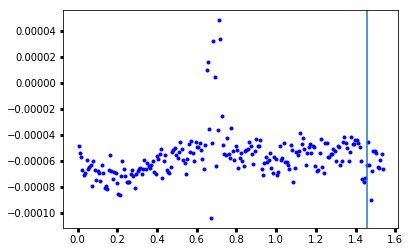

In [28]:
binned_time, binned_resids, binned_err = bindata(new_time, new_flux - new_sig, binsize=10./60./24.)
plt.plot(binned_time, binned_resids, 'b.')
plt.axvline(T0 + 0.5*per.to('day').value)

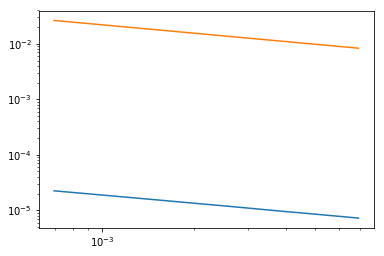

In [5]:
def calc_SR(w, x, params):

# Check how standard deviation for data points depends on binsize
binsizes = np.linspace(1., 10., 10)/60./24. # Convert from minutes to days

folded_time = filtered_time % per.to('day').value
med_binerr = np.array([])

for binsize in binsizes:
    binned_time, binned_flux, binned_err = bindata(folded_time, filtered_flux, binsize=binsize)
    
    med_binerr = np.append(med_binerr, np.nanmedian(binned_err))
    
plt.loglog(binsizes, med_binerr)
plt.loglog(binsizes, 1./(np.sqrt(binsizes)/binsizes[0]))